## Download Images from Smithsonian API

In [24]:
#https://towardsdatascience.com/how-to-download-an-image-using-python-38a75cfa21c
import requests # to get image from the web
import shutil # to save it locally

In [27]:
import json
with open('data_raw.json') as json_file:
    data = json.load(json_file)

In [28]:
for d in data:
    filename = './images/' + d["title"] + '.jpg'
    image_url = d["image_link"]
    # Open the url image, set stream to True, this will return the stream content.
    r = requests.get(image_url, stream = True)
    
        # Check if the image was retrieved successfully
    if r.status_code == 200:
        # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
        r.raw.decode_content = True

        # Open a local file with wb ( write binary ) permission.
        with open(filename,'wb') as f:
            shutil.copyfileobj(r.raw, f)

        print('Image sucessfully Downloaded: ',filename)
    else:
        print('Image Couldn\'t be retreived')

Image sucessfully Downloaded:  ./images/Bamboo Gate.jpg
Image sucessfully Downloaded:  ./images/Little Dancer of the "No".jpg
Image sucessfully Downloaded:  ./images/The Red Curtain.jpg
Image sucessfully Downloaded:  ./images/Butterflies.jpg
Image sucessfully Downloaded:  ./images/A Summer Girl.jpg
Image sucessfully Downloaded:  ./images/Fisher Boy.jpg
Image sucessfully Downloaded:  ./images/A Roundelay.jpg
Image sucessfully Downloaded:  ./images/O Tsuyu San.jpg
Image sucessfully Downloaded:  ./images/The Seats of the Mighty.jpg
Image sucessfully Downloaded:  ./images/A Southern Spring.jpg
Image sucessfully Downloaded:  ./images/From the Rice Fields.jpg
Image sucessfully Downloaded:  ./images/New Brooms.jpg
Image sucessfully Downloaded:  ./images/An Interlude.jpg
Image sucessfully Downloaded:  ./images/Oaxaca Market.jpg
Image sucessfully Downloaded:  ./images/In Mexico.jpg
Image sucessfully Downloaded:  ./images/Little Step-Sister.jpg
Image sucessfully Downloaded:  ./images/Church at C

## Register Cropped Images in JSON

In [30]:
import glob
import re
import json

In [4]:
files = glob.glob("./images/cropping/*.jpg",recursive=True)


In [8]:
# >>> r = re.compile("([a-zA-Z]+)([0-9]+)")
# >>> m = r.match("foobar12345")
# >>> m.group(1)
# 'foobar'
# >>> m.group(2)
# '12345'

In [5]:
group_dict = {
    
    "Child" : "Child",
    "Figur" : "Mom(Adult)",
    "Tools" : "Tool",
    "Lands" : "Landscape",
    "Animl" : "Animal",
    "Plant" : "Plant"
}

In [6]:
# Opening JSON file

data = []

with open('data.json') as json_file:
    data = json.load(json_file)


In [7]:
data_crop = []

r = re.compile("([a-zA-Z]+)([0-9]+)")

for f in files:
    m = r.match(f.split('/')[-1])
    title = f.split('/')[-1].split('@')[-1].split('.')[0]
    
    for d in data:
        if title == d["title"]:
            date = int(d["date"])
            
    if (date>=1894 and date<1899) or (date == 1901) or (date>=1914 and date<=1919):
        place = "USA"
        color = "#8CC6D4"
    elif date>=1910 and date<1912:
        place = "Mexico"
        color = "#EAD971"
    else:
        place = "Japan"
        color = "#BAABC8"
        
    
    
    item = {
        "itemid" : m.group(2),
        "group" : group_dict[m.group(1)],
        "title" : title,
        "date" : date,
        "place": place,
        "color" : color,
        "root" : f,
        "link" : d["record_link"],
        "width": d["width"],
        "height": d["height"]
        
    }
    
    data_crop.append(item)


In [8]:
with open("data_crop.json", "w") as outfile:
    json.dump(data_crop, outfile, indent = 4)

## Image Sorting (vgg16 + T-SNE)

In [1]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

Using TensorFlow backend.
/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtype

In [2]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

shape of x:  (1, 224, 224, 3)
data type:  float32


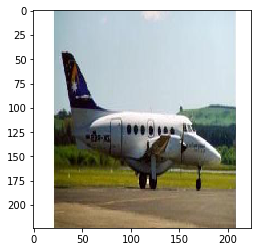

In [17]:
img, x = load_image("./src/101_ObjectCategories/airplanes/image_0019.jpg")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

In [18]:
predictions = model.predict(x)

# print out the 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))


predicted airliner with probability 0.923
predicted warplane with probability 0.031
predicted wing with probability 0.027
predicted space_shuttle with probability 0.011
predicted airship with probability 0.006


In [5]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [6]:
images_path = './images/cropping'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 234 images to analyze


In [7]:
import time
tic = time.clock()


features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.clock()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

analyzing image 0 / 234. Time: 0.0003 seconds.



/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


finished extracting features for 234 images


In [8]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=10)
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

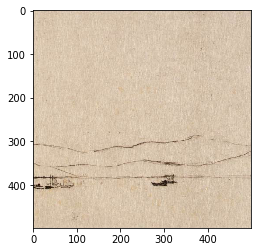

In [9]:
pca_features = pca.transform(features)

import random

# grab a random query image
query_image_idx = int(len(images) * random.random())

# let's display the image
img = image.load_img(images[query_image_idx])
plt.imshow(img)


In [10]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]


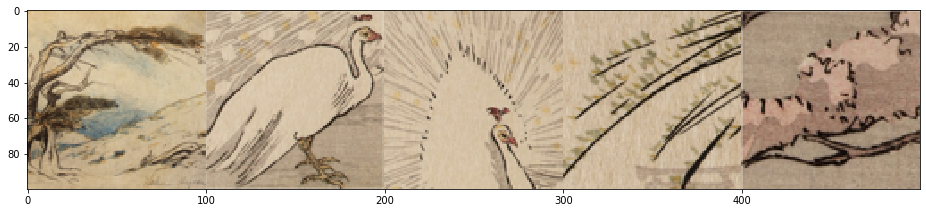

In [11]:
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)

In [12]:

for img, f in list(zip(images, pca_features))[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(img, f[0], f[1], f[2], f[3]))

image: ./images/cropping/Plant4@A Mexican Coquette.jpg, features: 12.61,-3.84,-9.29,3.71... 
image: ./images/cropping/Plant62@Little Pink Plum.jpg, features: 3.33,11.37,-18.24,6.39... 
image: ./images/cropping/Child111@Over the Garden Wall.jpg, features: 1.84,-14.58,11.62,-10.10... 
image: ./images/cropping/Plant79@Moon Bridge at Kameido.jpg, features: 4.98,34.69,-9.70,7.27... 
image: ./images/cropping/Child48@The Goblins 'l Git Yer.jpg, features: -11.02,-24.01,-1.37,-9.21... 


In [13]:
num_images_to_plot = 1000

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [14]:
from sklearn.manifold import TSNE

X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 234 samples in 0.000s...
[t-SNE] Computed neighbors for 234 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 234 / 234
[t-SNE] Mean sigma: 9.612401
[t-SNE] Computed conditional probabilities in 0.015s
[t-SNE] Iteration 50: error = 63.7277641, gradient norm = 0.6243632 (50 iterations in 0.044s)
[t-SNE] Iteration 100: error = 66.1196060, gradient norm = 0.5580956 (50 iterations in 0.034s)
[t-SNE] Iteration 150: error = 63.1556778, gradient norm = 0.6271130 (50 iterations in 0.033s)
[t-SNE] Iteration 200: error = 63.4391747, gradient norm = 0.6018546 (50 iterations in 0.033s)
[t-SNE] Iteration 250: error = 62.8314934, gradient norm = 0.5966370 (50 iterations in 0.032s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.831493
[t-SNE] Iteration 300: error = 1.0923605, gradient norm = 0.0062878 (50 iterations in 0.046s)
[t-SNE] Iteration 350: error = 0.9389587, gradient norm = 0.0110948 (

In [15]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

In [16]:

%matplotlib inline
import os
import random
import numpy as np
import json
import matplotlib.pyplot
import pickle
from matplotlib.pyplot import imshow
from PIL import Image
from sklearn.manifold import TSNE

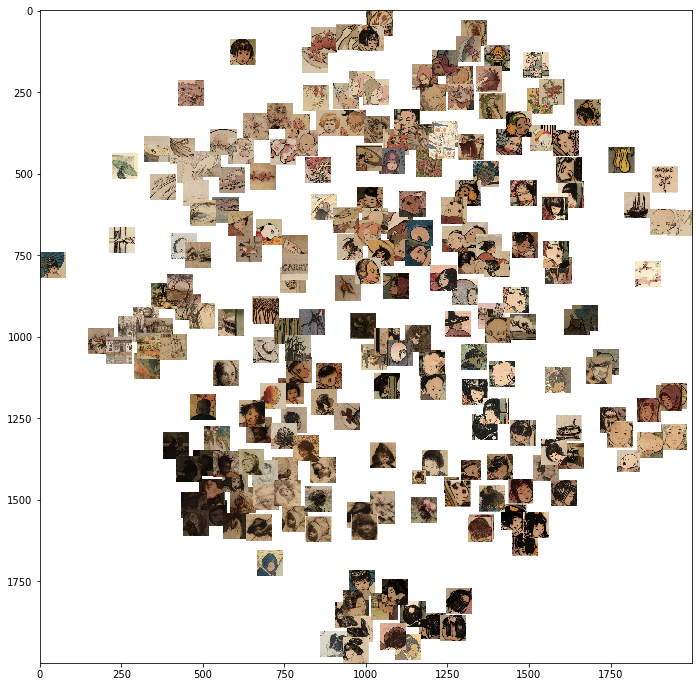

In [18]:


width = 2000
height = 2000
max_dim = 80

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

In [19]:
import rasterfairy

In [20]:
nx = 30
ny = 8
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

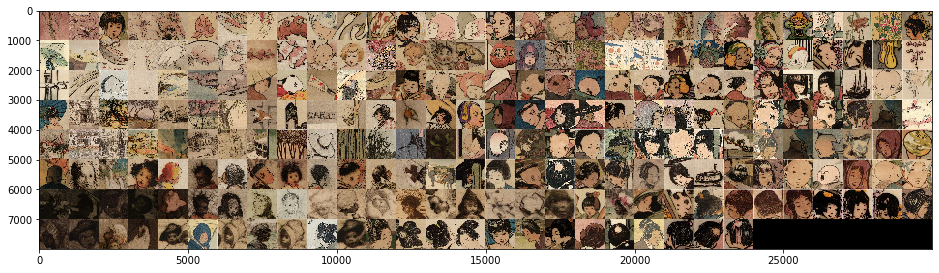

In [21]:
tile_width = 1000
tile_height = 1000

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)

In [22]:
img_pos = []

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    pos = int(idx_x + idx_y * 20)
    
    entry = {
        "img":img,
        "pos":pos
    }
    
    img_pos.append(entry)

def myFunc(e):
    return e['pos']

img_pos.sort(key=myFunc)

img_pos
    

[{'img': './images/cropping/Plant4@A Mexican Rebecca.jpg', 'pos': 0},
 {'img': './images/cropping/Plant120@An April Evening.jpg', 'pos': 1},
 {'img': './images/cropping/Child33@August.jpg', 'pos': 2},
 {'img': './images/cropping/Plant4@Cherry Snow.jpg', 'pos': 3},
 {'img': './images/cropping/Plant1@A Spring Poem.jpg', 'pos': 4},
 {'img': './images/cropping/Plant3@Confidences.jpg', 'pos': 5},
 {'img': './images/cropping/Tools58@A Weary Little Mother.jpg', 'pos': 6},
 {'img': './images/cropping/Tools118@The Good Luck Branch.jpg', 'pos': 7},
 {'img': './images/cropping/Tools6@The Daruma Branch.jpg', 'pos': 8},
 {'img': './images/cropping/Figur66@Mother and Child.jpg', 'pos': 9},
 {'img': './images/cropping/Animl55@Complaints.jpg', 'pos': 10},
 {'img': './images/cropping/Tools34@August.jpg', 'pos': 11},
 {'img': './images/cropping/Figur61@A Weary Little Mother.jpg', 'pos': 12},
 {'img': './images/cropping/Child43@A Japanese Madonna.jpg', 'pos': 13},
 {'img': './images/cropping/Figur42@A Ja

### recreating JSON of cropped images 

In [31]:
group_dict = {
    
    "Child" : "Children",
    "Figur" : "Mothers(Adults)",
    "Tools" : "Accessories",
    "Lands" : "Landscape",
    "Animl" : "Animals",
    "Plant" : "Plants"
}

# Opening JSON file

data = []

with open('data.json') as json_file:
    data = json.load(json_file)


data_crop = []

r = re.compile("([a-zA-Z]+)([0-9]+)")

#img_pos is the dictionary created from previous step
#sample entry: {'img': './images/cropping/Child15@The Joggling Board.jpg', 'pos': 94}]

for entry in img_pos:
    
    f = entry["img"]
    
    m = r.match(f.split('/')[-1])
    title = f.split('/')[-1].split('@')[-1].split('.')[0]
    
    for d in data:
        if title == d["title"]:
            date = int(d["date"])
            
            
    if (date>=1894 and date<1899) or (date == 1901) or (date>=1914 and date<=1919):
        place = "USA"
        color = "#8CC6D4"
    elif date>=1910 and date<1912:
        place = "Mexico"
        color = "#EAD971"
    else:
        place = "Japan"
        color = "#BAABC8"
        
    
    
    item = {
        "itemid" : m.group(2),
        "group" : group_dict[m.group(1)],
        "title" : title,
        "date" : date,
        "place": place,
        "color" : color,
        "root" : f,
        "link" : d["record_link"],
#         "width": d["width"],
#         "height": d["height"]
        
    }
    
    data_crop.append(item)




In [32]:
data_crop

[{'itemid': '4',
  'group': 'Plants',
  'title': 'A Mexican Rebecca',
  'date': 1912,
  'place': 'Japan',
  'color': '#BAABC8',
  'root': './images/cropping/Plant4@A Mexican Rebecca.jpg',
  'link': 'https://americanart.si.edu/collections/search/artwork/?id=11057'},
 {'itemid': '120',
  'group': 'Plants',
  'title': 'An April Evening',
  'date': 1910,
  'place': 'Mexico',
  'color': '#EAD971',
  'root': './images/cropping/Plant120@An April Evening.jpg',
  'link': 'https://americanart.si.edu/collections/search/artwork/?id=11057'},
 {'itemid': '33',
  'group': 'Children',
  'title': 'August',
  'date': 1914,
  'place': 'USA',
  'color': '#8CC6D4',
  'root': './images/cropping/Child33@August.jpg',
  'link': 'https://americanart.si.edu/collections/search/artwork/?id=11057'},
 {'itemid': '4',
  'group': 'Plants',
  'title': 'Cherry Snow',
  'date': 1906,
  'place': 'Japan',
  'color': '#BAABC8',
  'root': './images/cropping/Plant4@Cherry Snow.jpg',
  'link': 'https://americanart.si.edu/colle

In [33]:
with open("data_crop.json", "w") as outfile:
    json.dump(data_crop, outfile, indent = 4)